# ***Introduction to Radar Using Python and MATLAB***
## Andy Harrison - Copyright (C) 2019 Artech House
<br/>

# Stretch Processor
***

Referring to Section 8.4, stretch processing is an intrapulse compression technique used for processing waveforms of very large bandwidth.  It was originally developed to reduce the sampling requirements for large bandwidth, high range resolution systems such as synthetic aperture radar (SAR) systems.  While stretch processing may be applied to various forms of wide bandwidth waveforms, this discussion is focused on linear frequency modulation (LFM) waveforms.  A block diagram of a stretch processor is given in Figure 8.7, and in general, stretch processing consists of the following basic steps:

1. Mix the return signal with a reference signal.
2. Low-pass filter the mixed signals.
3. Analog-to-digital conversion of the low-pass filtered signals.
4. Fourier transform of the digital signals.

The first step in stretch processing is to mix the return signal with a reference signal.  The reference signal is typically generated with the same frequency slope as the transmitted signal.  The transmitted LFM signal may be written as (Equation 8.36)

\begin{equation}
    s(t) = \exp\left[j\, 2 \pi \left(f_0 t + \frac{\beta}{2} t ^ 2\right)\right] \hspace{0.5in} 0\le t \le \tau_p,
\end{equation}

The return signal from a point scatterer is written as (Equation 8.37)

\begin{equation}
    s_r(t) = A\, \exp\left[j\, 2 \pi \left(f_0(t - t_0) + \frac{\beta}{2}(t - t_0) ^ 2\right)\right], 
\end{equation}

The factor, $A$, is a constant related to the target's radar cross section, antenna gain, path loss, and other factors.  The reference signal is written as (Equation 8.38)

\begin{equation}
    s_{ref}(t) = \exp\left[ j\, 2 \pi \left( f_0(t - t_{ref}) + \frac{\beta}{2}(t - t_{ref}) ^ 2 \right) \right],
\end{equation}

where $t_{ref}$ is the reference time of the signal, which must closely match $t_0$. This leads to the following requirement on the pulsewidth of the reference signal (Equation 8.39)

\begin{equation}
    \tau_{ref} \ge t_r + \tau_p \hspace{0.5in} \text{(s)},
\end{equation}

where $t_r$ is the range of time over which stretch processing is to be employed.  This is expressed as $t_r = t_{max} - t_{min}$.  The second requirement is $ t_{ref} - t_{min} \le t_0 \le t_{max} + t_{ref}$. Now that the requirements on the reference signal have been specified, the output of the mixing step is written as (Equation 8.40)

\begin{equation}\label{eq:sp_output_mixed}
    s_o(t) = A\, \exp\Big[ j\, 2 \pi f_0 (t_0 - t_{ref}) + j\, 2 \pi \beta (t_0 - t_{ref})t + j\, \pi \beta (t_{ref}^2 - t_0^2) \Big].
\end{equation}

The instantaneous frequency is the time derivative of the phase, which is written as (Equation 8.41)

\begin{equation}
    f_i = \frac{1}{2 \pi}\frac{d\phi(t)}{dt} \hspace{0.5in} \text{(Hz)},
\end{equation}

where $\phi(t)$ is the phase of the signal which is simply (Equation 8.42)

\begin{equation}
    \phi(t) = 2 \pi f_0 (t_0 - t_{ref}) + 2 \pi \beta (t_0 - t_{ref})t + \pi \beta \left(t_{ref}^2 - t_0^2\right) \hspace{0.25in} \text{(rad)}.
\end{equation}

The instantaneous frequency is then (Equation 8.43)

\begin{equation}\label{eq:inst_freq_sp}
    f_i = \beta(t_0 - t_{ref}) \hspace{0.5in} \text{(Hz)}.
\end{equation}

This allows the time delay of the target to be written as (Equation 8.44)

\begin{equation}
    t_0 = \frac{f_i}{\beta} + t_{ref} \hspace{0.5in} \text{(s)}.
\end{equation}

Therefore, the target range is related to the instantaneous frequency as (Equation 8.45)
\begin{equation}
    r_0 = \frac{c}{2}\bigg(\frac{f_i}{B}\tau_p + t_{ref}\bigg) \hspace{0.5in} \text{(m)}.
\end{equation}

The expression in (Equation 8.43) indicates the resulting instantaneous frequency is constant and related to the range to the target. Performing analog-to-digital sampling on the signal output from the mixer only requires sampling at the maximum instantaneous frequency in (Equation 8.43), rather than the full bandwidth.
***

Set the bandwidth (Hz), the pulsewidth (s), the length of the range window (m), the target range (m) and the target radar cross section (m^2)

In [1]:
bandwidth = 1e9

pulsewidth = 10e-4

range_window_length = 50.0

target_range = [10.0, 20.0, 30.0]

target_rcs = [1.0, 10.0, 3.0]

Calculate the number of samples for stretch processing

In [2]:
from numpy import ceil

from scipy.constants import c

number_of_samples = int(ceil(4 * bandwidth * range_window_length / c))

Set the window type

In [3]:
window_type = 'Rectangular'

Get the window coefficients using `scipy.signal.windows`

In [4]:
from scipy.signal.windows import hann, hamming, blackmanharris, kaiser 

from numpy import ones


if window_type == 'Kaiser':

    coefficients = kaiser(number_of_samples, 6, True)

elif window_type == 'Blackman-Harris':

    coefficients = blackmanharris(number_of_samples, True)

elif window_type == 'Hanning':

    coefficients = hann(number_of_samples, True)

elif window_type == 'Hamming':

    coefficients = hamming(number_of_samples, True)

elif window_type == 'Rectangular':

    coefficients = ones(number_of_samples)

Get the time sampling using the `linspace` routine from `scipy`

In [5]:
from numpy import linspace

t, dt = linspace(-0.5 * pulsewidth, 0.5 * pulsewidth, number_of_samples, retstep=True)

Calculate the sampled signal after the mixing process

In [6]:
from numpy import zeros, sqrt, exp

from scipy.constants import pi


so = zeros(number_of_samples, dtype=complex)

for r, rcs in zip(target_range, target_rcs):

    so += sqrt(rcs) * exp(1j * 2.0 * pi * bandwidth / pulsewidth * (2 * r / c) * t)

Perform the FFT on the sampled signal using the routines from `fftpack`

In [7]:
from scipy.fftpack import fftfreq, fft, fftshift


# Fourier transform

so = fftshift(fft(so * coefficients, 4 * number_of_samples))



# FFT frequencies

frequencies = fftshift(fftfreq(4 * number_of_samples, dt))

Calculate the range window (m) from the frequencies (Hz)

In [8]:
# Range window

range_window = 0.5 * frequencies * c * pulsewidth / bandwidth

Display the results of stretch processing using the `matplotlib` routines

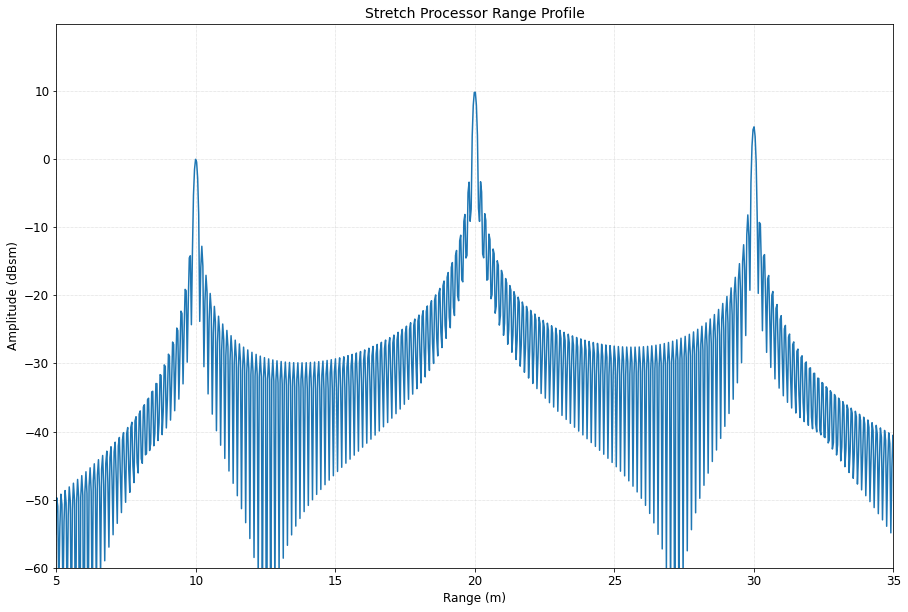

In [9]:
from matplotlib import pyplot as plt

from numpy import log10, finfo


# Set the figure size

plt.rcParams["figure.figsize"] = (15, 10)



# Create the line plot

plt.plot(range_window, 20.0 * log10(abs(so) / number_of_samples + finfo(float).eps), '')

plt.xlim(min(target_range) - 5, max(target_range) + 5)

plt.ylim(-60, max(20.0 * log10(abs(so) / number_of_samples)) + 10)



# Set the x and y axis labels

plt.xlabel("Range (m)", size=12)

plt.ylabel("Amplitude (dBsm)", size=12)



# Turn on the grid

plt.grid(linestyle=':', linewidth=0.5)



# Set the plot title and labels

plt.title('Stretch Processor Range Profile', size=14)



# Set the tick label size

plt.tick_params(labelsize=12)